In [1]:
import tifffile
from skimage.color import rgb2gray
import numpy as np

import matplotlib.pyplot as plt

In [2]:
fp = '/Users/erikstorrs/Downloads/ch_CH4.tif'

tf = tifffile.TiffFile(fp)
page = tf.pages[0]
rgb = page.asarray()
rgb

array([[[ 0, 18, 18],
        [ 0, 20, 20],
        [ 0, 21, 21],
        ...,
        [ 0, 46, 46],
        [ 0, 53, 53],
        [ 0, 46, 46]],

       [[ 0, 24, 24],
        [ 0, 24, 24],
        [ 0, 26, 26],
        ...,
        [ 0, 39, 39],
        [ 0, 48, 48],
        [ 0, 52, 52]],

       [[ 0, 40, 40],
        [ 0, 27, 27],
        [ 0, 23, 23],
        ...,
        [ 0, 38, 38],
        [ 0, 45, 45],
        [ 0, 55, 55]],

       ...,

       [[ 0, 42, 42],
        [ 0, 50, 50],
        [ 0, 49, 49],
        ...,
        [ 0, 41, 41],
        [ 0, 41, 41],
        [ 0, 38, 38]],

       [[ 0, 51, 51],
        [ 0, 55, 55],
        [ 0, 56, 56],
        ...,
        [ 0, 38, 38],
        [ 0, 42, 42],
        [ 0, 37, 37]],

       [[ 0, 45, 45],
        [ 0, 51, 51],
        [ 0, 54, 54],
        ...,
        [ 0, 34, 34],
        [ 0, 41, 41],
        [ 0, 45, 45]]], shape=(360, 480, 3), dtype=uint8)

In [4]:
X = (rgb2gray(rgb) * 255).astype(np.uint8)
X

array([[14, 15, 16, ..., 36, 41, 36],
       [18, 18, 20, ..., 30, 37, 40],
       [31, 21, 18, ..., 29, 35, 43],
       ...,
       [33, 39, 38, ..., 32, 32, 29],
       [40, 43, 44, ..., 29, 33, 29],
       [35, 40, 42, ..., 26, 32, 35]], shape=(360, 480), dtype=uint8)

In [8]:
def adjust_brightness(arr: np.ndarray, min_value: int, max_value: int) -> np.ndarray:
    """
    Adjust brightness by clamping and linearly rescaling values to [0, 255].
    Parameters:
        arr (np.ndarray): Input uint8 array.
        min_value (int): Values below this are set to 0.
        max_value (int): Values above this are set to 255.
    Returns:
        np.ndarray: Brightness-adjusted uint8 array.
    """
    arr = arr.astype(np.float32)
    result = np.clip((arr - min_value) / (max_value - min_value), 0, 1)
    result = (result * 255).astype(np.uint8)
    return result

converted = adjust_brightness(X, 1, 50.11)
converted

array([[ 67,  72,  77, ..., 181, 207, 181],
       [ 88,  88,  98, ..., 150, 186, 202],
       [155, 103,  88, ..., 145, 176, 218],
       ...,
       [166, 197, 192, ..., 160, 160, 145],
       [202, 218, 223, ..., 145, 166, 145],
       [176, 202, 212, ..., 129, 160, 176]], shape=(360, 480), dtype=uint8)

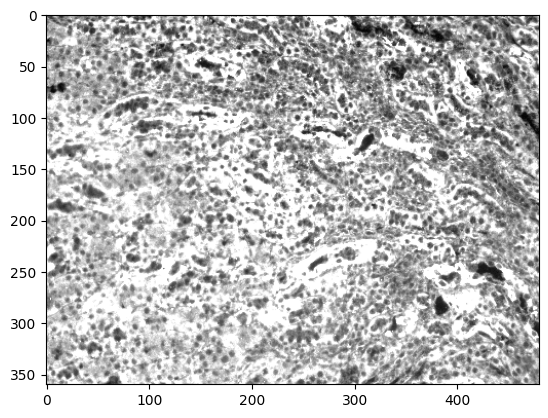

In [16]:
plt.imshow(converted, cmap='gray')

In [ ]:
tifffile.imwrite('/Users/erikstorrs/Downloads/img.tif', converted)

In [17]:
rgb = np.repeat(np.expand_dims(converted, -1), 3, -1)
rgb.shape

(360, 480, 3)

In [18]:
cyan_rgb = ((rgb.astype(np.float32) / 255) * [0, 255, 255]).astype(np.uint8)
cyan_rgb.shape

(360, 480, 3)

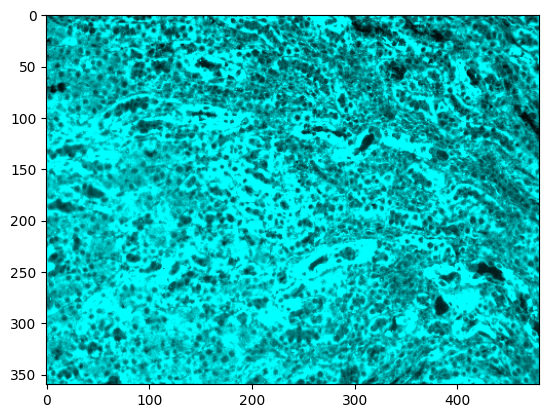

In [19]:
plt.imshow(cyan_rgb)

In [20]:
tifffile.imwrite('/Users/erikstorrs/Downloads/cyan_img.tif', cyan_rgb)

In [32]:
from pydantic_extra_types.color import Color
from einops import repeat, rearrange

In [23]:
a, b, c = [converted.copy() for i in range(3)]
a.shape, b.shape, c.shape

((360, 480), (360, 480), (360, 480))

In [29]:
stacked = np.stack((a, b, c), axis=0)
stacked.shape

(3, 360, 480)

In [33]:
def to_pseudocolor(data, colors=None, min_values=None, max_values=None, gammas=None):
    """
    data - (c, h, w)
    """
    if min_values is None:
        min_values = np.zeros((data.shape[0],), dtype=data.dtype)
    if max_values is None:
        max_values = np.full((data.shape[0],), np.iinfo(np.uint8).max, dtype=data.dtype)

    if colors is None:
        n = data.shape[0]
        colors = np.asarray(vis_utils.get_cmap(n)[:n]) * 255
        colors = [tuple(c) for c in colors] 

    rgbs = np.asarray([Color(c).as_rgb_tuple() for c in colors]) / 255.
        
    scaled = data / np.iinfo(data.dtype).max
    
    min_values = np.asarray(min_values) / np.iinfo(data.dtype).max
    max_values = np.asarray(max_values) / np.iinfo(data.dtype).max
    if gammas is not None:
        gammas = np.asarray(gammas)
        
    for i, val in enumerate(min_values):
        scaled[i][scaled[i] < val] = 0.
    for i, val in enumerate(max_values):
        scaled[i][scaled[i] > val] = val

    scaled -= scaled.min((1, 2), keepdims=True)
    scaled /= scaled.max((1, 2), keepdims=True)

    # gamma
    if gammas is not None:
        scaled **= rearrange(gammas, 'n -> n 1 1')

    scaled += 1e-16

    stacked = repeat(scaled, 'c h w -> c 3 h w ') * rearrange(rgbs, 'c n -> c n 1 1')

    rgb = rearrange(stacked.sum(0), 'c h w -> h w c')
    rgb[rgb>1] = 1.
    
    return rgb

In [37]:
colors = ['cyan', 'limegreen', 'yellow']
new_rgb = to_pseudocolor(stacked, colors=colors)
new_rgb = (new_rgb * 255).astype(np.uint8)
new_rgb.shape

(360, 480, 3)

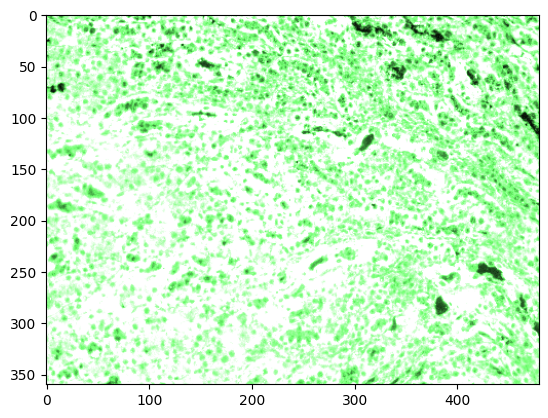

In [38]:
plt.imshow(new_rgb)

In [39]:
new_rgb.max()

np.uint8(255)